# ML Model for Cyber Security Intrusion

In [1]:
from collections import defaultdict
import csv
from itertools import combinations 
import numpy as np

Transactions_list = []  # a list of transactions
Items_names = {}  # Lookup item ID to name
Items_ids = {}  # Lookup item name to ID

Items = None  # a list of item IDs, normally an increasing sequence of numbers

# Process the data
with open('./TrafficLabelling /Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv', 'r') as fin:
    reader = csv.reader(fin, delimiter=',')
    item_id = 0
    count = 0
    for row in reader:
        if count == 0:
            count= count +1
            continue
        transaction = []
        for item in row:
            if item not in Items_ids:
                if item != '0':
                    Items_ids[item] = item_id
                    Items_names[item_id] = item
                    item_id += 1
                else:
                    continue
            transaction += [Items_ids[item]]
        count = count+1
        Transactions_list += [transaction]
        
M, N = len(Items_ids), len(Transactions_list)

Items = np.arange(0,M)

# Information, sanity
print(f'M={M} items, N={N} transactions')

M=1948905 items, N=225745 transactions


## Data Exploration

In [2]:
import os
import pandas as pd

path = os.getcwd() + '/TrafficLabelling /'
print(path)

datasets = {}
count = 0
for filenames in os.listdir(path):
    datasets[count] = filenames
    count = count+1
        
dataset1 = datasets[0]
print(dataset1)

/home/yahya/HW/HW10_YahyaAlSabeh/TrafficLabelling /
Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv


In [3]:
import chardet


def csvParser(datasetPath):
    path = os.getcwd() + '/TrafficLabelling /'

    try:
        df = pd.read_csv(path+datasetPath, delimiter=',', encoding='utf-8')
    except:
        df = pd.read_csv(path+datasetPath, delimiter=',', encoding='cp1252')

    df = df.dropna(axis = 0, how = 'all')
    df = df.rename(columns = lambda x: x.strip())
    
    return df

In [4]:
dat1_df = csvParser(dataset1)

/tmp/ipykernel_11563/2529990858.py:10: DtypeWarning: Columns (0,1,3,6,84) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path+datasetPath, delimiter=',', encoding='cp1252')


In [5]:
print(dataset1)
dat1_df.info()

Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv
<class 'pandas.core.frame.DataFrame'>
Int64Index: 170366 entries, 0 to 170365
Data columns (total 85 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Flow ID                      170366 non-null  object 
 1   Source IP                    170366 non-null  object 
 2   Source Port                  170366 non-null  float64
 3   Destination IP               170366 non-null  object 
 4   Destination Port             170366 non-null  float64
 5   Protocol                     170366 non-null  float64
 6   Timestamp                    170366 non-null  object 
 7   Flow Duration                170366 non-null  float64
 8   Total Fwd Packets            170366 non-null  float64
 9   Total Backward Packets       170366 non-null  float64
 10  Total Length of Fwd Packets  170366 non-null  float64
 11  Total Length of Bwd Packets  170366 non-null  float64
 12  Fwd

***For a particular connection, source to destination, let's look at the data.***

In [6]:
#Let's look at the objects
object_columns = dat1_df.select_dtypes(include=['object']).columns 
dat1_df[dat1_df[object_columns[0]] == dat1_df[object_columns[0]][0]]

,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,192.168.10.3-192.168.10.50-389-33898-6,192.168.10.50,33898.0,192.168.10.3,389.0,6.0,6/7/2017 8:59,113095465.0,48.0,24.0,...,32.0,203985.5,5.758373e+05,1629110.0,379.0,13800000.0,4277541.062,16500000.0,6737603.0,BENIGN
339,192.168.10.3-192.168.10.50-389-33898-6,192.168.10.50,33898.0,192.168.10.3,389.0,6.0,6/7/2017 9:01,77005492.0,59.0,30.0,...,32.0,2016858.0,1.960389e+06,4854877.0,347.0,10800000.0,3939240.701,14900000.0,5204804.0,BENIGN
862,192.168.10.3-192.168.10.50-389-33898-6,192.168.10.50,33898.0,192.168.10.3,389.0,6.0,6/7/2017 9:02,2.0,1.0,2.0,...,32.0,0.0,0.000000e+00,0.0,0.0,0.0,0.000,0.0,0.0,BENIGN


In [7]:
len(dat1_df['Flow ID'].unique())

89866

Since there are so many flow IDs that aare just not non unique, and the information of the Source IP and Source Port is synonymous. We can eliminate FlowID, Source IP, and Destination IP. This is all redundant information... Let's edit the parser to reflect the change...

Furthermore the date and time stamp is difficult to interpret and I'm not sure how applicable it is to the nature of the data we are working with (what describes a malware attack and where it comes from). So we will drop that column as well.

***Pick a machine learning methodology and justify your choice.***

Attempting Apriori analysis on this dataset is going to be too memory intensive. Also we have the ground truth available for all 8 datasets, so instead we should focus on employing classification algorithms.

In [8]:
def csvParser(datasetPath):
    path = os.getcwd() + '/TrafficLabelling /'

    try:
        df = pd.read_csv(path+datasetPath, delimiter=',', encoding='utf-8')
    except:
        df = pd.read_csv(path+datasetPath, delimiter=',', encoding='cp1252')

    df = df.dropna(axis = 0, how = 'all')
    df = df.rename(columns = lambda x: x.strip())
    droppable = ['Flow ID', 'Source IP', 'Destination IP', 'Timestamp']
    df = df.drop(columns=droppable)
    
    return df

In [9]:
dat1_df = csvParser(dataset1)
dat1_df

/tmp/ipykernel_11563/969273516.py:7: DtypeWarning: Columns (0,1,3,6,84) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path+datasetPath, delimiter=',', encoding='cp1252')


,Source Port,Destination Port,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,33898.0,389.0,6.0,113095465.0,48.0,24.0,9668.0,10012.0,403.0,0.0,...,32.0,203985.500,5.758373e+05,1629110.0,379.0,13800000.0,4.277541e+06,16500000.0,6737603.0,BENIGN
1,33904.0,389.0,6.0,113473706.0,68.0,40.0,11364.0,12718.0,403.0,0.0,...,32.0,178326.875,5.034269e+05,1424245.0,325.0,13800000.0,4.229413e+06,16500000.0,6945512.0,BENIGN
2,0.0,0.0,0.0,119945515.0,150.0,0.0,0.0,0.0,0.0,0.0,...,0.0,6909777.333,1.170000e+07,20400000.0,6.0,24400000.0,2.430000e+07,60100000.0,5702188.0,BENIGN
3,59135.0,443.0,6.0,60261928.0,9.0,7.0,2330.0,4221.0,1093.0,0.0,...,20.0,0.000,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.0,BENIGN
4,59555.0,53.0,17.0,269.0,2.0,2.0,102.0,322.0,51.0,51.0,...,32.0,0.000,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.0,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170361,443.0,55641.0,6.0,49.0,1.0,3.0,6.0,18.0,6.0,6.0,...,20.0,0.000,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.0,BENIGN
170362,443.0,45337.0,6.0,217.0,2.0,1.0,31.0,6.0,31.0,0.0,...,32.0,0.000,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.0,BENIGN
170363,60148.0,22.0,6.0,1387547.0,41.0,46.0,2728.0,6634.0,456.0,0.0,...,32.0,0.000,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.0,BENIGN
170364,60146.0,22.0,6.0,207.0,1.0,1.0,0.0,0.0,0.0,0.0,...,32.0,0.000,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.0,BENIGN


***Exploring source/destination bytes, packets, ports and the duration features***

Data Exploration

36921


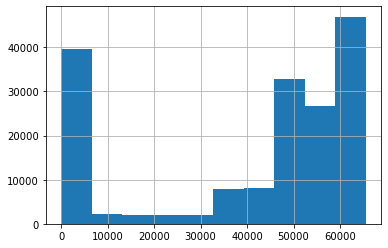

In [10]:
dat1_df['Source Port'].hist()
print(len(dat1_df['Source Port'].unique()))

There is a lot of unique Source Ports, but few of them are used quite frequently.

<Axes: >

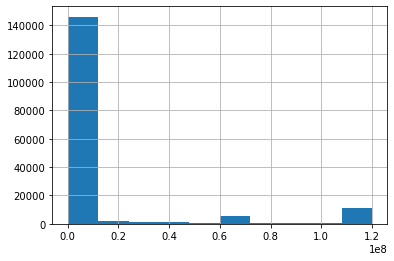

In [11]:
dat1_df['Flow Duration'].hist()

In [12]:
dat1_df.columns

Index(['Source Port', 'Destination Port', 'Protocol', 'Flow Duration',
       'Total Fwd Packets', 'Total Backward Packets',
       'Total Length of Fwd Packets', 'Total Length of Bwd Packets',
       'Fwd Packet Length Max', 'Fwd Packet Length Min',
       'Fwd Packet Length Mean', 'Fwd Packet Length Std',
       'Bwd Packet Length Max', 'Bwd Packet Length Min',
       'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s',
       'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max',
       'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std',
       'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean',
       'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags',
       'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Min Packet Length', 'Max Packet Length', 'Packet Length Mean',
       'Packet Length Std', 'Packet Length Variance', 'FIN Flag 

In [13]:
dat1_df

,Source Port,Destination Port,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,33898.0,389.0,6.0,113095465.0,48.0,24.0,9668.0,10012.0,403.0,0.0,...,32.0,203985.500,5.758373e+05,1629110.0,379.0,13800000.0,4.277541e+06,16500000.0,6737603.0,BENIGN
1,33904.0,389.0,6.0,113473706.0,68.0,40.0,11364.0,12718.0,403.0,0.0,...,32.0,178326.875,5.034269e+05,1424245.0,325.0,13800000.0,4.229413e+06,16500000.0,6945512.0,BENIGN
2,0.0,0.0,0.0,119945515.0,150.0,0.0,0.0,0.0,0.0,0.0,...,0.0,6909777.333,1.170000e+07,20400000.0,6.0,24400000.0,2.430000e+07,60100000.0,5702188.0,BENIGN
3,59135.0,443.0,6.0,60261928.0,9.0,7.0,2330.0,4221.0,1093.0,0.0,...,20.0,0.000,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.0,BENIGN
4,59555.0,53.0,17.0,269.0,2.0,2.0,102.0,322.0,51.0,51.0,...,32.0,0.000,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.0,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170361,443.0,55641.0,6.0,49.0,1.0,3.0,6.0,18.0,6.0,6.0,...,20.0,0.000,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.0,BENIGN
170362,443.0,45337.0,6.0,217.0,2.0,1.0,31.0,6.0,31.0,0.0,...,32.0,0.000,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.0,BENIGN
170363,60148.0,22.0,6.0,1387547.0,41.0,46.0,2728.0,6634.0,456.0,0.0,...,32.0,0.000,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.0,BENIGN
170364,60146.0,22.0,6.0,207.0,1.0,1.0,0.0,0.0,0.0,0.0,...,32.0,0.000,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.0,BENIGN


***Find out important networking port
numbers and one-hot-encode them. Unimportant port numbers or source port numbers can
be assigned to a feature called 'other ports'***

There seem to be a lot of data here. We probably can only one-hot encode data for the most frequent ports so we will need a function to count and rank them.

In [14]:
dat1_df['Source Port'].values

array([3.3898e+04, 3.3904e+04, 0.0000e+00, ..., 6.0148e+04, 6.0146e+04,
       2.2000e+01])

In [15]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

def PortConvert(df):
    common_ports = {7:'Echo', 19:'Chargen', 20:'FTP', 21:'FTP', 22:'SSH/SCP',
                23:'Telnet', 25:'SMTP', 42:'WINS Replication', 43:'WHOIS',
                49:'TACACS', 53:'DNS', 67:'DHCP', 68:'DHCP', 69:'TFTP',
                70:'Gopher', 79:'Finger', 80:'HTTP', 88:'Kerberos', 
                102:'MS Exchange', 110:'POP3', 113:'Ident', 
                119:'NNTP (Usenet)', 123:'NTP', 135:'Microsoft RPC', 
                137:'NetBIOS', 138:'NetBIOS', 139:'NetBIOS', 143:'IMAP4',
                161:'SNMP', 162:'SNMP', 177:'XDMCP', 179:'BGP', 
                201:'AppleTalk', 264:'BGMP', 318:'TSP', 381:'HP Openview',
                382:'HP Openview', 383:'HP Openview', 389:'LDAP', 
                411:'DIRECT CONNECT', 412:'DIRECT CONNECT', 
                443:'HTTP OVER SSL', 445:'Microsoft DS', 464:'Kerberos',
                465:'SMTP OVER SSL', 497:'Retrospect', 500:'ISAKMP', 
                512:'rexec', 513:'rlogin', 514:'syslog', 515:'LPD/LPR',
                520:'RIP', 521:'RIP', 540:'UUCP', 554:'RTSP', 546:'DHCP',
                547:'DHCP', 560:'rmonitor', 563:'NNTP OVER SSL', 587:'SMTP',
                591:'FileMaker', 593:'Microsoft DCOM', 631:'Internet Printing',
                636:'LDAP OVER SSL', 639:'MSDP (PIM)', 646:'LDP (MPLS)',
                666:'DOOM', 691:'MS Exchange', 860:'iSCSI', 873:'rsync',
                902:'VMware Server', 989:'FTP', 990:'FTP', 993:'IMAP4', 
                995:'POP3', 1025:'Microsoft RPC', 
                1026:'Windows Messenger', 1027:'Windows Messenger', 1028:'Windows Messenger', 1029:'Windows Messenger',
                1080:'SOCKS PROXY', 1194:'OpenVPN', 1214:'KAZAA',
                1241:'Nessus', 1311:'Dell OpenManage', 1337:'WASTE', 1433:'Microsoft SQL',
                1434:'Microsoft SQL', 1512:'WINS', 1589:'Cisco VQP', 1701:'L2TP',
                1723:'MS PPTP', 1725:'STEAM', 1741:'CiscoWorks 2000',
                1755:'MS MEDIA SERVER', 1812:'RADIUS', 1813:'RADIUS',
                1863:'MSN', 1985:'Cisco HSRP', 2000:'Cisco SCCP', 2002:'Cisco ACS',
                2049:'NFS', 2082:'cPanel', 2083:'cPanel', 2100:'Oracle XDB',
                2222:'DirectAdmin', 2302:'HALO', 2483:'Oracle DB', 2484:'Oracle DB',
                2745:'BAGLE.H', 2967:'Symantec AV', 3050:'Interbase DB', 
                3074:'XBOX LIVE', 3124:'HTTP Proxy', 3128:'HTTP Proxy', 
                3222:'GLBP', 3260:'iSCSI Target', 3306:'MySQL', 
                3389:'Terminal Ser ver', 3689:'iTunes', 3690:'Subversion',
                3724:'World Of Warcraft', 3784:'Ventrilo', 3785:'Ventrilo',
                4333:'mSQL', 4444:'BLASTER', 4664:'Google Desktop', 
                4672:'EMULE', 4899:'Radmin', 5000:'UPnP', 5001:'Slingbox',
                5001:'iperf', 5004:'RTP', 5005:'RTP', 5050:'YAHOO! MESSENGER',
                5060:'SIP', 5190:'AIM/ICQ', 5222:'XMPP/Jabber', 
                5223:'XMPP/Jabber', 5432:'PostgreSQL', 5500:'VNC Ser ver',
                5554:'SASSER', 5631:'pcAnywhere', 5632:'pcAnywhere',
                5800:'VNC', 6000:'X11', 6001:'X11', 6112:'BATTLE.NET',
                6129:'DameWare', 6257:'WINMX', 6346:'GNUTELLA', 
                6347:'GNUTELLA', 6500:'GAMESPY ARCADE', 6566:'SANE',
                6588:'AnalogX', 6665:'IRC', 6669:'IRC', 6679:'IRC', 6697:'IRC',
                8000:'Internet Radio', 8080:'HTTP Proxy', 8086:'Kaspersky AV',
                8087:'Kaspersky AV', 8118:'Privoxy', 8200:'VMware Server',
                8500:'Adobe ColdFusion', 8767:'TEAMSPEAK', 8866:'BAGLE.B',
                9100:'HP JetDirect', 9119:'MXIT', 9800:'WebDAV', 
                9898:'DABBER', 9988:'RBOT/SPYBOT', 9999:'Urchin', 
                10000:'Webmin', 10000:'BackupExec', 10113:'NetIQ',
                10114:'NetIQ', 10115:'NetIQ', 10116:'NetIQ', 11371:'OpenPGP',
                12345:'NETBUS', 13720:'NetBackup', 13721:'NetBackup', 19226:'AdminSecure',
                19638:'Ensim', 20000:'Usermin', 24800:'Synergy'}
    count = 0
    for port in df['Source Port'].values:
        df.loc[count,'Source Port'] = common_ports[int(port)] if int(port) in common_ports.keys() else 'other'
        count = count +1
    count = 0
    for port in df['Destination Port'].values:
        df.loc[count,'Destination Port'] = common_ports[int(port)] if int(port) in common_ports.keys() else 'other'
        count = count +1
    return df

def OneHotEnc(df,  featureName):
    for i in featureName:
        ranks = dat1_df[i].value_counts()
        rank_names = list(ranks.iloc[0:20].index) #Let's just pick the top 20 ports.
        unrank_names = list(ranks.iloc[20:].index)
        print(rank_names)
        df[i] = df[i].replace(unrank_names, -1)
        df = pd.get_dummies(df, columns = [i])
    return df


In [16]:
datF = PortConvert(dat1_df)
datF

,Source Port,Destination Port,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,other,LDAP,6.0,113095465.0,48.0,24.0,9668.0,10012.0,403.0,0.0,...,32.0,203985.500,5.758373e+05,1629110.0,379.0,13800000.0,4.277541e+06,16500000.0,6737603.0,BENIGN
1,other,LDAP,6.0,113473706.0,68.0,40.0,11364.0,12718.0,403.0,0.0,...,32.0,178326.875,5.034269e+05,1424245.0,325.0,13800000.0,4.229413e+06,16500000.0,6945512.0,BENIGN
2,other,other,0.0,119945515.0,150.0,0.0,0.0,0.0,0.0,0.0,...,0.0,6909777.333,1.170000e+07,20400000.0,6.0,24400000.0,2.430000e+07,60100000.0,5702188.0,BENIGN
3,other,HTTP OVER SSL,6.0,60261928.0,9.0,7.0,2330.0,4221.0,1093.0,0.0,...,20.0,0.000,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.0,BENIGN
4,other,DNS,17.0,269.0,2.0,2.0,102.0,322.0,51.0,51.0,...,32.0,0.000,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.0,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170361,HTTP OVER SSL,other,6.0,49.0,1.0,3.0,6.0,18.0,6.0,6.0,...,20.0,0.000,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.0,BENIGN
170362,HTTP OVER SSL,other,6.0,217.0,2.0,1.0,31.0,6.0,31.0,0.0,...,32.0,0.000,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.0,BENIGN
170363,other,SSH/SCP,6.0,1387547.0,41.0,46.0,2728.0,6634.0,456.0,0.0,...,32.0,0.000,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.0,BENIGN
170364,other,SSH/SCP,6.0,207.0,1.0,1.0,0.0,0.0,0.0,0.0,...,32.0,0.000,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.0,BENIGN


In [17]:
df = OneHotEnc(dat1_df,['Source Port', 'Destination Port', 'Protocol'])
df

['other', 'HTTP OVER SSL', 'HTTP', 'NTP', 'NetBIOS', 'SSH/SCP', 'FTP', 'Kerberos', 'LDAP', 'DNS', 'Microsoft RPC', 'Microsoft DS', 'Windows Messenger', 'SMTP OVER SSL', 'WINS Replication', 'IRC', 'Cisco VQP', 'Oracle DB', 'HTTP Proxy', 'Ventrilo']
['DNS', 'HTTP OVER SSL', 'other', 'HTTP', 'NTP', 'SSH/SCP', 'NetBIOS', 'Kerberos', 'LDAP', 'FTP', 'SMTP OVER SSL', 'Microsoft DS', 'Microsoft RPC', 'HTTP Proxy', 'WINS Replication', 'Windows Messenger', 'Ventrilo', 'RADIUS', 'Interbase DB', 'Oracle DB']
[6.0, 17.0, 0.0]


,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,Destination Port_RADIUS,Destination Port_SMTP OVER SSL,Destination Port_SSH/SCP,Destination Port_Ventrilo,Destination Port_WINS Replication,Destination Port_Windows Messenger,Destination Port_other,Protocol_0.0,Protocol_6.0,Protocol_17.0
0,113095465.0,48.0,24.0,9668.0,10012.0,403.0,0.0,201.416667,203.548293,923.0,...,0,0,0,0,0,0,0,0,1,0
1,113473706.0,68.0,40.0,11364.0,12718.0,403.0,0.0,167.117647,171.919413,1139.0,...,0,0,0,0,0,0,0,0,1,0
2,119945515.0,150.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0,0,0,0,0,0,1,1,0,0
3,60261928.0,9.0,7.0,2330.0,4221.0,1093.0,0.0,258.888889,409.702161,1460.0,...,0,0,0,0,0,0,0,0,1,0
4,269.0,2.0,2.0,102.0,322.0,51.0,51.0,51.000000,0.000000,161.0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170361,49.0,1.0,3.0,6.0,18.0,6.0,6.0,6.000000,0.000000,6.0,...,0,0,0,0,0,0,1,0,1,0
170362,217.0,2.0,1.0,31.0,6.0,31.0,0.0,15.500000,21.920310,6.0,...,0,0,0,0,0,0,1,0,1,0
170363,1387547.0,41.0,46.0,2728.0,6634.0,456.0,0.0,66.536585,110.129945,976.0,...,0,0,1,0,0,0,0,0,1,0
170364,207.0,1.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0,0,1,0,0,0,0,0,1,0


In [18]:
desc=df.describe()
desc.to_csv('desc', sep='\t')

#We need to standardize a lot of this data. There is a lot of outliers present.

In [19]:
df.columns[0:78]

Index(['Flow Duration', 'Total Fwd Packets', 'Total Backward Packets',
       'Total Length of Fwd Packets', 'Total Length of Bwd Packets',
       'Fwd Packet Length Max', 'Fwd Packet Length Min',
       'Fwd Packet Length Mean', 'Fwd Packet Length Std',
       'Bwd Packet Length Max', 'Bwd Packet Length Min',
       'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s',
       'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max',
       'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std',
       'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean',
       'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags',
       'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Min Packet Length', 'Max Packet Length', 'Packet Length Mean',
       'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count',
       'SYN Flag Count', 'RST Flag Count', 'PS

In [20]:
df.replace([float('inf'), float('-inf')], np.nan, inplace=True)
df = df.dropna()
df

,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,Destination Port_RADIUS,Destination Port_SMTP OVER SSL,Destination Port_SSH/SCP,Destination Port_Ventrilo,Destination Port_WINS Replication,Destination Port_Windows Messenger,Destination Port_other,Protocol_0.0,Protocol_6.0,Protocol_17.0
0,113095465.0,48.0,24.0,9668.0,10012.0,403.0,0.0,201.416667,203.548293,923.0,...,0,0,0,0,0,0,0,0,1,0
1,113473706.0,68.0,40.0,11364.0,12718.0,403.0,0.0,167.117647,171.919413,1139.0,...,0,0,0,0,0,0,0,0,1,0
2,119945515.0,150.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0,0,0,0,0,0,1,1,0,0
3,60261928.0,9.0,7.0,2330.0,4221.0,1093.0,0.0,258.888889,409.702161,1460.0,...,0,0,0,0,0,0,0,0,1,0
4,269.0,2.0,2.0,102.0,322.0,51.0,51.0,51.000000,0.000000,161.0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170361,49.0,1.0,3.0,6.0,18.0,6.0,6.0,6.000000,0.000000,6.0,...,0,0,0,0,0,0,1,0,1,0
170362,217.0,2.0,1.0,31.0,6.0,31.0,0.0,15.500000,21.920310,6.0,...,0,0,0,0,0,0,1,0,1,0
170363,1387547.0,41.0,46.0,2728.0,6634.0,456.0,0.0,66.536585,110.129945,976.0,...,0,0,1,0,0,0,0,0,1,0
170364,207.0,1.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0,0,1,0,0,0,0,0,1,0


In [21]:
df.reset_index(drop=True)

,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,Destination Port_RADIUS,Destination Port_SMTP OVER SSL,Destination Port_SSH/SCP,Destination Port_Ventrilo,Destination Port_WINS Replication,Destination Port_Windows Messenger,Destination Port_other,Protocol_0.0,Protocol_6.0,Protocol_17.0
0,113095465.0,48.0,24.0,9668.0,10012.0,403.0,0.0,201.416667,203.548293,923.0,...,0,0,0,0,0,0,0,0,1,0
1,113473706.0,68.0,40.0,11364.0,12718.0,403.0,0.0,167.117647,171.919413,1139.0,...,0,0,0,0,0,0,0,0,1,0
2,119945515.0,150.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0,0,0,0,0,0,1,1,0,0
3,60261928.0,9.0,7.0,2330.0,4221.0,1093.0,0.0,258.888889,409.702161,1460.0,...,0,0,0,0,0,0,0,0,1,0
4,269.0,2.0,2.0,102.0,322.0,51.0,51.0,51.000000,0.000000,161.0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170226,49.0,1.0,3.0,6.0,18.0,6.0,6.0,6.000000,0.000000,6.0,...,0,0,0,0,0,0,1,0,1,0
170227,217.0,2.0,1.0,31.0,6.0,31.0,0.0,15.500000,21.920310,6.0,...,0,0,0,0,0,0,1,0,1,0
170228,1387547.0,41.0,46.0,2728.0,6634.0,456.0,0.0,66.536585,110.129945,976.0,...,0,0,1,0,0,0,0,0,1,0
170229,207.0,1.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0,0,1,0,0,0,0,0,1,0


In [22]:
df_num = df.select_dtypes(include=[float])
df_num.columns

Index(['Flow Duration', 'Total Fwd Packets', 'Total Backward Packets',
       'Total Length of Fwd Packets', 'Total Length of Bwd Packets',
       'Fwd Packet Length Max', 'Fwd Packet Length Min',
       'Fwd Packet Length Mean', 'Fwd Packet Length Std',
       'Bwd Packet Length Max', 'Bwd Packet Length Min',
       'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s',
       'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max',
       'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std',
       'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean',
       'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags',
       'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Min Packet Length', 'Max Packet Length', 'Packet Length Mean',
       'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count',
       'SYN Flag Count', 'RST Flag Count', 'PS

In [23]:
from sklearn.preprocessing import RobustScaler

def standardize(X, numerical): 
    rc = RobustScaler()
    X[numerical] = rc.fit_transform(X[numerical])
    
    return X


standard = df.columns[0:77]
df_standard = standardize(df, standard)
df_standard

/tmp/ipykernel_11563/2403892847.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[numerical] = rc.fit_transform(X[numerical])


,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,Destination Port_RADIUS,Destination Port_SMTP OVER SSL,Destination Port_SSH/SCP,Destination Port_Ventrilo,Destination Port_WINS Replication,Destination Port_Windows Messenger,Destination Port_other,Protocol_0.0,Protocol_6.0,Protocol_17.0
0,135.945089,15.333333,22.0,82.051282,30.677019,9.783784,-0.146341,3.966424,11.372774,4.911765,...,0,0,0,0,0,0,0,0,1,0
1,136.399875,22.000000,38.0,96.547009,39.080745,9.783784,-0.146341,3.133923,9.605586,6.182353,...,0,0,0,0,0,0,0,0,1,0
2,144.181401,49.333333,-2.0,-0.581197,-0.416149,-1.108108,-0.146341,-0.922330,0.000000,-0.517647,...,0,0,0,0,0,0,1,1,0,0
3,72.419496,2.333333,5.0,19.333333,12.692547,28.432432,-0.146341,5.361381,22.891128,8.070588,...,0,0,0,0,0,0,0,0,1,0
4,-0.037467,0.000000,0.0,0.290598,0.583851,0.270270,1.097561,0.315534,0.000000,0.429412,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170361,-0.037732,-0.333333,1.0,-0.529915,-0.360248,-0.945946,0.000000,-0.776699,0.000000,-0.482353,...,0,0,0,0,0,0,1,0,1,0
170362,-0.037530,0.000000,-1.0,-0.316239,-0.397516,-0.270270,-0.146341,-0.546117,1.224745,-0.482353,...,0,0,0,0,0,0,1,0,1,0
170363,1.630558,13.000000,44.0,22.735043,20.186335,11.216216,-0.146341,0.692636,6.153247,5.223529,...,0,0,1,0,0,0,0,0,1,0
170364,-0.037542,-0.333333,-1.0,-0.581197,-0.416149,-1.108108,-0.146341,-0.922330,0.000000,-0.517647,...,0,0,1,0,0,0,0,0,1,0


***Process the class feature/category as binary classes for supervised learning,
assign BENIGN to value 0 and the rest to value 1. Check its balance for the Dataset 1.***

***Finally we will relabel our target variable***

In [24]:
# Process labels assigning BENIGN to value 0 and the rest to value 1
def target_encoder(df):
    df['Label'] = df['Label'].apply(lambda label: 1 if label != 'BENIGN' else 0)
    return df

df_complete = target_encoder(df_standard)
df_complete

/tmp/ipykernel_11563/3105509074.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Label'] = df['Label'].apply(lambda label: 1 if label != 'BENIGN' else 0)


,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,Destination Port_RADIUS,Destination Port_SMTP OVER SSL,Destination Port_SSH/SCP,Destination Port_Ventrilo,Destination Port_WINS Replication,Destination Port_Windows Messenger,Destination Port_other,Protocol_0.0,Protocol_6.0,Protocol_17.0
0,135.945089,15.333333,22.0,82.051282,30.677019,9.783784,-0.146341,3.966424,11.372774,4.911765,...,0,0,0,0,0,0,0,0,1,0
1,136.399875,22.000000,38.0,96.547009,39.080745,9.783784,-0.146341,3.133923,9.605586,6.182353,...,0,0,0,0,0,0,0,0,1,0
2,144.181401,49.333333,-2.0,-0.581197,-0.416149,-1.108108,-0.146341,-0.922330,0.000000,-0.517647,...,0,0,0,0,0,0,1,1,0,0
3,72.419496,2.333333,5.0,19.333333,12.692547,28.432432,-0.146341,5.361381,22.891128,8.070588,...,0,0,0,0,0,0,0,0,1,0
4,-0.037467,0.000000,0.0,0.290598,0.583851,0.270270,1.097561,0.315534,0.000000,0.429412,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170361,-0.037732,-0.333333,1.0,-0.529915,-0.360248,-0.945946,0.000000,-0.776699,0.000000,-0.482353,...,0,0,0,0,0,0,1,0,1,0
170362,-0.037530,0.000000,-1.0,-0.316239,-0.397516,-0.270270,-0.146341,-0.546117,1.224745,-0.482353,...,0,0,0,0,0,0,1,0,1,0
170363,1.630558,13.000000,44.0,22.735043,20.186335,11.216216,-0.146341,0.692636,6.153247,5.223529,...,0,0,1,0,0,0,0,0,1,0
170364,-0.037542,-0.333333,-1.0,-0.581197,-0.416149,-1.108108,-0.146341,-0.922330,0.000000,-0.517647,...,0,0,1,0,0,0,0,0,1,0


In [25]:
df_complete['Label'].unique()

array([0, 1])

***Attempt a few classifier models and report their 10-fold CV performance.***

Let's test a few classifiers and report their 10-fold CV.

***Warning Long Calculation***

In [26]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score

def kfold_eval_docs(_clf, _X, _y):
    accs = []
    precs = []
    recall = []
    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
    for train_index, test_index in kf.split(_X, _y):
        _clf.fit(_X[train_index], _y[train_index])
        ypred = _clf.predict(_X[test_index])
        accs += [accuracy_score(_y[test_index], ypred)]
        precs += [precision_score(_y[test_index], ypred)]
        recall += [recall_score(_y[test_index], ypred)]
        
    return np.array(accs), np.array(precs), np.array(recall)

In [27]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

knn = KNeighborsClassifier(n_jobs=4)
rf = RandomForestClassifier(n_jobs=4, random_state=1)
nn = MLPClassifier(random_state=1)
dt = DecisionTreeClassifier(random_state=1)
gnb = GaussianNB()

In [28]:
def classifierRoullete(_classifiers, dataframe):
    X = dataframe.loc[:, dataframe.columns != 'Label']
    y = dataframe.loc[:, dataframe.columns == 'Label']
    
    X_arr = X.values
    y_arr = y.values.ravel()
    y_arr = y_arr.astype(int)
    for classifier in _classifiers.keys():
        %timeit 
        accs, precs, recall = kfold_eval_docs(_classifiers[classifier], X_arr, y_arr)
        print(classifier, " accuracy = ", np.mean(accs), " standard deviations = ", np.std(accs), " precision = ", np.mean(precs), " recall = ", np.mean(recall))
    print(X_arr[0:10],y_arr[0:10])
    
classifiers = {'KNeighborsClassifier':knn, 'Random Forest':rf, 'Neural Network':nn, 'Decision Tree':dt, 'Gaussian Naive Bayes':gnb}
classifierRoullete(classifiers, df_complete)

KNeighborsClassifier  accuracy =  0.999500679352327  standard deviations =  0.0001293660466338521  precision =  0.9848015026908474  recall =  0.9761467889908257
Random Forest  accuracy =  0.999770899576822  standard deviations =  0.000158608889777878  precision =  0.9976807986116096  recall =  0.9844036697247706
Neural Network  accuracy =  0.9990189791597744  standard deviations =  0.00033443089576156224  precision =  0.9912950011960644  recall =  0.9316513761467891
Decision Tree  accuracy =  0.9998531402146542  standard deviations =  8.410904425514289e-05  precision =  0.9940635050828799  recall =  0.9944954128440366
Gaussian Naive Bayes  accuracy =  0.19207428898992915  standard deviations =  0.0033978637329579193  precision =  0.015603570263227378  recall =  1.0
[[ 1.35945089e+02  1.53333333e+01  2.20000000e+01 ...  0.00000000e+00
   1.00000000e+00  0.00000000e+00]
 [ 1.36399875e+02  2.20000000e+01  3.80000000e+01 ...  0.00000000e+00
   1.00000000e+00  0.00000000e+00]
 [ 1.44181401e

The decision tree had the best results, and time efficiency. Going forward if we plan on making a modular design that is efficient. We should probably explore the idea of feature reduction, eventhough our confidence values are exceptionally good as is, the computation time is extremely long. Let me just see the correlation graph of this dataset.

The Decision Tree algorithm also had the fastest speed, and the smallest standard deviation. What's most important is also reporting the TPR and FPR. Since we are trying to catch all cyber attacks, we should pick the algorithm that maximizes the TPR (the sensitivity).

In [30]:
#See the performance barely changed. So feature reduction was very helpful!!! Let's make it into a function
def feature_Reduction(dataframe):
    X = dataframe.loc[:, dataframe.columns != 'Label']
    y = dataframe.loc[:, dataframe.columns == 'Label']

    X_arr = X.values
    y_arr = y.values.ravel()
    y_arr = y_arr.astype(int)

    corrs = np.array([np.correlate(X_arr[:,j], y_arr)[0] for j in range(X.shape[1])])

    # Reverse sort, numpy array negation reverses the order
    ranks = np.argsort((-corrs))

    # Display top-9 and bot-5
    rankings = [(f'{corrs[j]:.1f}', X.columns[j]) for j in ranks]
    delcols = [(j, f'{corrs[j]:.1f}', X.columns[j]) for j in ranks if abs(corrs[j])<=500]
    
    dd = [d[2] for d in delcols]

    # Drop those columns, axis=1
    Xpp = dataframe.drop(columns=dd)
    
    return Xpp

In [31]:
Xpp = feature_Reduction(df_complete)

In [32]:
Xpp

,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Std,Flow IAT Mean,Flow IAT Std,...,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Label,Source Port_other,Destination Port_HTTP,Protocol_6.0
0,135.945089,15.333333,22.0,82.051282,30.677019,3.966424,11.372774,231.080951,10.006538,39.957328,...,22.0,30.677019,0.062736,8.524590,7.333333,1.000000,0,1,0,1
1,136.399875,22.000000,38.0,96.547009,39.080745,3.133923,9.605586,208.261294,6.631309,33.146661,...,38.0,39.080745,0.040644,8.532787,12.666667,1.000000,0,1,0,1
2,144.181401,49.333333,-2.0,-0.581197,-0.416149,-0.922330,0.000000,0.000000,5.011514,45.872684,...,-2.0,-0.416149,-0.007079,0.000000,-0.333333,-1.666667,0,1,0,0
3,72.419496,2.333333,5.0,19.333333,12.692547,5.361381,22.891128,653.594166,25.377680,134.721074,...,5.0,12.692547,0.992921,2.106557,2.333333,0.000000,0,1,0,1
4,-0.037467,0.000000,0.0,0.290598,0.583851,0.315534,0.000000,0.000000,-0.091435,0.000386,...,0.0,0.583851,-0.007079,0.000000,0.000000,1.000000,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170361,-0.037732,-0.333333,1.0,-0.529915,-0.360248,-0.776699,0.000000,0.000000,-0.091899,-0.000687,...,1.0,-0.360248,-0.006957,0.004098,-0.333333,0.000000,0,0,0,1
170362,-0.037530,0.000000,-1.0,-0.316239,-0.397516,-0.546117,1.224745,0.000000,-0.091315,-0.000528,...,-1.0,-0.397516,0.009764,0.004098,-0.333333,1.000000,0,0,0,1
170363,1.630558,13.000000,44.0,22.735043,20.186335,0.692636,6.153247,307.913979,0.010284,0.912257,...,44.0,20.186335,3.557061,1.000000,7.666667,1.000000,0,1,0,1
170364,-0.037542,-0.333333,-1.0,-0.581197,-0.416149,-0.922330,0.000000,0.000000,-0.090691,-0.000903,...,-1.0,-0.416149,0.028439,1.000000,-0.333333,1.000000,0,1,0,1


***Let's try again***

In [33]:
classifierRoullete(classifiers, Xpp)

KNeighborsClassifier  accuracy =  0.999530050688277  standard deviations =  0.00012322108318451209  precision =  0.9880104246395993  recall =  0.9752293577981652
Random Forest  accuracy =  0.9997297787403067  standard deviations =  0.00011807449564342331  precision =  0.9949327931803047  recall =  0.9839449541284402
Neural Network  accuracy =  0.9975092573642075  standard deviations =  0.0025276636813643502  precision =  0.9105971242550017  recall =  0.9261467889908255
Decision Tree  accuracy =  0.999788521757273  standard deviations =  0.00011807452991057253  precision =  0.991369221219693  recall =  0.9922018348623853
Gaussian Naive Bayes  accuracy =  0.19462376601603582  standard deviations =  0.003094623504302754  precision =  0.015533893124683288  recall =  0.9922018348623854
[[ 1.35945089e+02  1.53333333e+01  2.20000000e+01  8.20512821e+01
   3.06770186e+01  3.96642395e+00  1.13727737e+01  2.31080951e+02
   1.00065378e+01  3.99573275e+01  2.89243186e+01 -7.81250000e-03
   3.08714

***Convert our code to be used for the remaining 7 datasets, i.e. Datasets 2-8.***

In [34]:
def RunAll():
    import os
    import pandas as pd

    path = os.getcwd() + '/TrafficLabelling /'
    print(path)

    datasets = {}
    count = 0
    for filenames in os.listdir(path):
        datasets[count] = filenames
        count = count+1
    
    count = 0
    for i in datasets.keys():
        if count==0:
            count = count + 1
            continue
        
        print('Working on dataset ',i) 
        dataset = datasets[i]
        #print('Before', dataset)
        dataset = csvParser(dataset) #parses file into dataframe also eliminates IP columns and unnecessart flow column
        dataset = PortConvert(dataset) #convert ports into port names
        dataset = OneHotEnc(dataset,['Source Port', 'Destination Port', 'Protocol']) #one hot encode the ports and protocol
        
        dataset.replace([float('inf'), float('-inf')], np.nan, inplace=True)
        dataset = dataset.dropna()  #replace and drop infinite rows
        dataset = dataset.reset_index(drop=True) #reset index
        df_num = dataset.select_dtypes(include=[float])  
        
        standard = df_num.columns #standardize these columns
        dataset = standardize(dataset, standard)
        
        dataset = target_encoder(dataset)  #encode the target
        dataset = feature_Reduction(dataset) #feature reduction
        
        #print('After', dataset)
        
        dt = DecisionTreeClassifier(random_state=1)  #ML algorithm 

        X = dataset.loc[:, dataset.columns != 'Label']
        y = dataset.loc[:, dataset.columns == 'Label']

        X_arr = X.values
        y_arr = y.values.ravel()
        y_arr = y_arr.astype(int)
        
        accs, precs, recall = kfold_eval_docs(dt, X_arr, y_arr)
        print('Decision Tree Dataset', i, ": accuracy = ", np.mean(accs), " standard deviations = ", np.std(accs), " precision = ", np.mean(precs), " recall = ", np.mean(recall))
        count = count + 1
        

***Pick a classifier algorithm and report its evaluation for the remaining 7 datasets.
Note that one dataset has a single class, which might need an unsupervised learning.***

In [35]:
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

RunAll()

/home/yahya/HW/HW10_YahyaAlSabeh/TrafficLabelling /
Working on dataset  1
['other', 'HTTP OVER SSL', 'HTTP', 'NTP', 'NetBIOS', 'SSH/SCP', 'FTP', -1, 'Kerberos', 'LDAP', 'DNS', 'Microsoft RPC', 'Microsoft DS', 'Windows Messenger', 'SMTP OVER SSL', 'WINS Replication', 'Ventrilo', 'Cisco VQP', 'Oracle DB', 'HTTP Proxy']
['DNS', 'HTTP OVER SSL', 'other', 'HTTP', 'NTP', 'SSH/SCP', 'NetBIOS', 'Kerberos', 'LDAP', 'FTP', 'SMTP OVER SSL', 'Microsoft DS', 'Microsoft RPC', 'HTTP Proxy', 'WINS Replication', 'Windows Messenger', 'Ventrilo', 'RADIUS', 'Interbase DB', 'Oracle DB']
[6.0, 17.0, 0.0]
Decision Tree Dataset 1 : accuracy =  0.9998892384032608  standard deviations =  6.934772868947357e-05  precision =  0.9998828521570754  recall =  0.999921889645577
Working on dataset  2
['other', 'HTTP OVER SSL', 'HTTP', 'NTP', 'NetBIOS', 'SSH/SCP', 'FTP', -1, 'Kerberos', 'LDAP', 'DNS', 'Microsoft RPC', 'Microsoft DS', 'Windows Messenger', 'SMTP OVER SSL', 'WINS Replication', 'Ventrilo', 'Cisco VQP', 'Orac

ValueError: Found array with 0 feature(s) (shape=(476532, 0)) while a minimum of 1 is required by DecisionTreeClassifier.

***There was an error in the last dataset that I just couldn't figure out why....***

***10. [10 pts] Briefly write up your thoughts about developing a machine learning model where
you are not a subject matter expert, such as, developing a cybersecurity intrusion detection
pipeline as in this assignment.***

We started this analysis thinking if it would be possible to perform Apriori analysis, to find associations between the data and a malicious attack. However, we quickly noticed that there is too much data to do this. So we switched into performing a classification task.

In our classification there are strategies used to gain maximum performance, first we eliminated all redundant features, then we did feature ranking to eliminate features with low correlation, finally we encoded the most common port numbers using one-hot encoding. One-hot encoding is adviseable here because port connections are one to one. Also the protocol was one-hot encoded as well although this did not make much of a difference and could be label encoded.

After standardizing our features we had fantastic performance of nearly 99.9% and the highest TPR using the Decision Tree, it also enjoyed the fastest processing speed. So we decided to continue with that classifier for the rest of our analysis.